In [24]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import roc_auc_score

import matplotlib.pylab as plt

In [25]:
df = pd.read_csv('solar data.csv')

# Step 3: Quick look at data
print("Shape of dataset:", df.shape)
print(df.head())

print(df.columns)

Shape of dataset: (4213, 21)
   temperature_2_m_above_gnd  relative_humidity_2_m_above_gnd  \
0                       2.17                               31   
1                       2.31                               27   
2                       3.65                               33   
3                       5.82                               30   
4                       7.73                               27   

   mean_sea_level_pressure_MSL  total_precipitation_sfc  snowfall_amount_sfc  \
0                       1035.0                      0.0                  0.0   
1                       1035.1                      0.0                  0.0   
2                       1035.4                      0.0                  0.0   
3                       1035.4                      0.0                  0.0   
4                       1034.4                      0.0                  0.0   

   total_cloud_cover_sfc  high_cloud_cover_high_cld_lay  \
0                    0.0                

In [26]:

# Step 4: Split into features (X) and target (y)
X = df.drop('generated_power_kw', axis=1)  # all input columns
y = df['generated_power_kw']               # target column

# Step 5: Split into train and test (80% train, 20% test)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Step 6: Split training set into actual training and validation (80/20)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

print("Train set shape:", X_train.shape)
print("Validation set shape:", X_valid.shape)
print("Test set shape:", X_test.shape)

# Step 7: Create XGBoost Datasets
train_data = xgb.DMatrix(X_train, label=y_train)
valid_data = xgb.DMatrix(X_valid, label=y_valid)

Train set shape: (2696, 20)
Validation set shape: (674, 20)
Test set shape: (843, 20)


In [27]:

#setting parameters to the model
params = {
    'objective': 'reg:squarederror',  # regression task
    'eval_metric': 'rmse',            # root mean squared error
    'eta': 0.1,                       # learning rate
    'max_depth': 6,                   # tree depth
    'subsample': 0.8,                 # sample fraction
    'colsample_bytree': 0.8,          # feature fraction
    'seed': 42
}

In [28]:
evals = [(train_data, 'train'), (valid_data, 'valid')]

model = xgb.train(
    params,
    train_data,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=50
)

[0]	train-rmse:865.37644	valid-rmse:856.23462
[50]	train-rmse:239.50761	valid-rmse:446.29087
[100]	train-rmse:160.06102	valid-rmse:441.03263
[150]	train-rmse:111.80180	valid-rmse:440.17055
[200]	train-rmse:83.32995	valid-rmse:439.33941
[250]	train-rmse:63.79508	valid-rmse:438.27501
[300]	train-rmse:48.60630	valid-rmse:437.77988
[350]	train-rmse:38.15122	valid-rmse:437.90842
[354]	train-rmse:37.22659	valid-rmse:437.86018


In [29]:
# Step: Test evaluation
test_data = xgb.DMatrix(X_test, label=y_test)
y_pred = model.predict(test_data)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test MAE:", mae)
print("Test R²:", r2)

Test MSE: 154695.1926957419
Test RMSE: 393.3130975390241
Test MAE: 248.11068680483746
Test R²: 0.8306498863958591


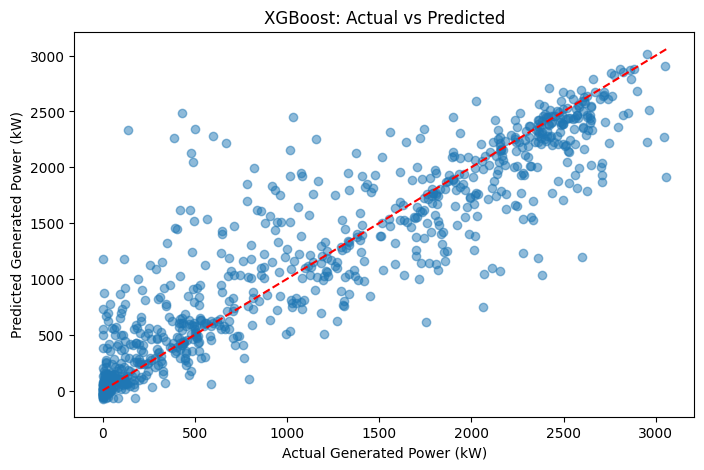

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linestyle='--')
plt.xlabel("Actual Generated Power (kW)")
plt.ylabel("Predicted Generated Power (kW)")
plt.title("XGBoost: Actual vs Predicted")
plt.show()